# Домашнее задание 2: Классификация изображений CIFAR-10
**Выполнил:** Самородов Юрий Сергеевич
**Курс:** Науки о данных, Семестр 3  
**Группа:** М08-401 

**Дата:** 21 сентября 2025

**Задача:** Реализация и сравнение трех подходов к классификации изображений:
1. Простая CNN
2. Transfer Learning (предобученная модель)
3. Vision Transformer (ViT)

**Цель:** Достичь accuracy не ниже 90% на тестовой выборке хотя бы одной из моделей.

## 1. Импорт библиотек и настройка

In [1]:
# Проверка среды
import sys
print("Версия Python:", sys.version)

# Импорт основных библиотек
try:
    import tensorflow as tf
    print(f"TensorFlow: {tf.__version__}")
    print(f"Доступно GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")
except ImportError:
    print("Устанавливаем TensorFlow...")
    !pip install tensorflow
    import tensorflow as tf

Версия Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


2025-09-29 16:38:12.825298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759163893.004057      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759163893.061949      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow: 2.18.0
Доступно GPU: True


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Установка случайных состояний для воспроизводимости
np.random.seed(42)
tf.random.set_seed(42)

print(f"Версия TensorFlow: {tf.__version__}")
print(f"Версия TensorFlow Hub: {hub.__version__}")
print(f"Версия Keras: {keras.__version__}")
print(f"GPU устройства: {tf.config.list_physical_devices('GPU')}")
if tf.config.list_physical_devices('GPU'):
    print("Включен рост памяти GPU")
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)

Версия TensorFlow: 2.18.0
Версия TensorFlow Hub: 0.16.1
Версия Keras: 3.8.0
GPU устройства: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Включен рост памяти GPU


## 2. Загрузка и анализ данных

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Данные обучения: (50000, 32, 32, 3)
Тестовые данные: (10000, 32, 32, 3)
Количество классов: 10
Классы: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

После разделения:
Тренировка: (40000, 32, 32, 3), (40000, 10)
Валидация: (10000, 32, 32, 3), (10000, 10)
Тест: (10000, 32, 32, 3), (10000, 10)


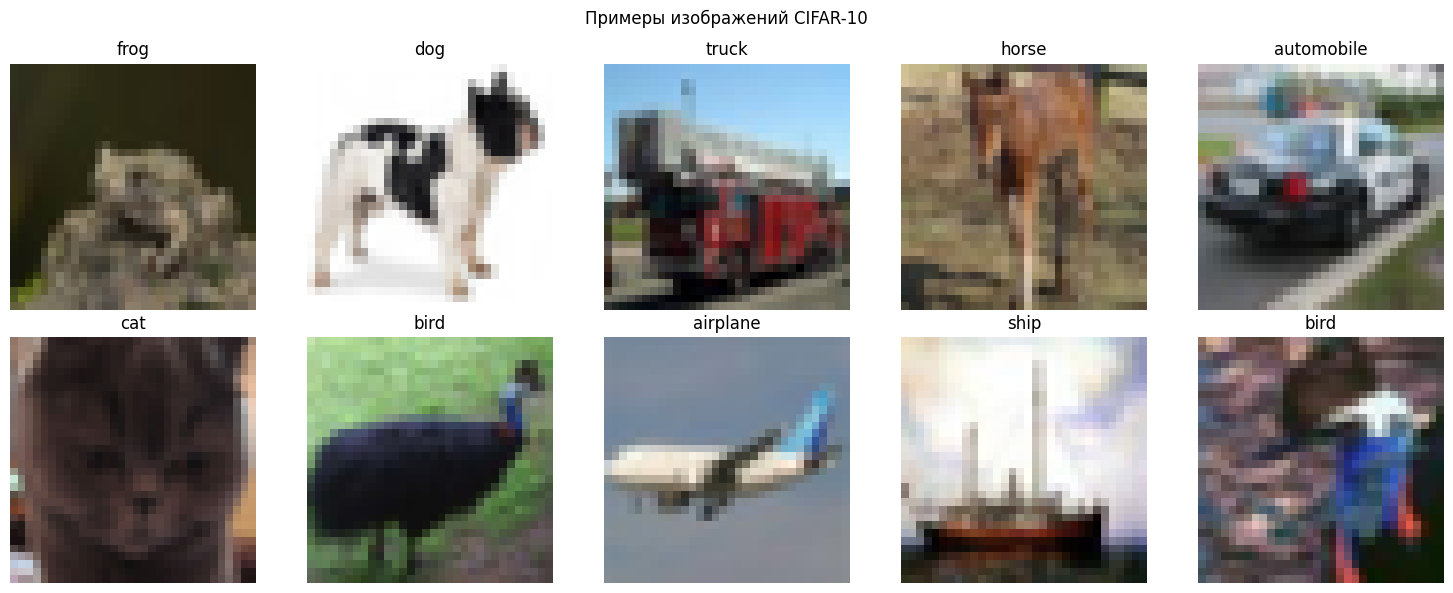

In [3]:
# Загрузка и подготовка данных CIFAR-10
from tensorflow.keras.datasets import cifar10

# Загрузка данных
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

# Нормализация к диапазону [0, 1]
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Преобразование меток
y_train_full = y_train_full.flatten()
y_test = y_test.flatten()

# Названия классов CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

print(f"Данные обучения: {X_train_full.shape}")
print(f"Тестовые данные: {X_test.shape}")
print(f"Количество классов: {num_classes}")
print(f"Классы: {class_names}")

# Разделение на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_full
)

# Преобразование в категориальный формат
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"\nПосле разделения:")
print(f"Тренировка: {X_train.shape}, {y_train_cat.shape}")
print(f"Валидация: {X_val.shape}, {y_val_cat.shape}")
print(f"Тест: {X_test.shape}, {y_test_cat.shape}")

# Показать примеры изображений
def show_samples(images, labels, class_names, n_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    indices = np.random.choice(len(images), n_samples, replace=False)
    
    for i, idx in enumerate(indices):
        axes[i].imshow(images[idx])
        axes[i].set_title(f"{class_names[labels[idx]]}")
        axes[i].axis('off')
    
    plt.suptitle("Примеры изображений CIFAR-10")
    plt.tight_layout()
    plt.show()

show_samples(X_train, y_train, class_names)

## Модель 1: Продвинутая CNN с ResNet-подобными блоками

In [4]:
def create_resnet_block(x, filters, kernel_size=3, stride=1, activation='relu'):
    """Создание ResNet-подобного блока"""
    # Сохраняем входной тензор для skip connection
    shortcut = x
    
    # Первый conv слой
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    
    # Второй conv слой
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Если размерности не совпадают, адаптируем shortcut
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # Сложение и активация
    x = layers.Add()([x, shortcut])
    x = layers.Activation(activation)(x)
    
    return x

def create_advanced_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """Создание продвинутой CNN модели с ResNet блоками"""
    
    inputs = layers.Input(shape=input_shape)
    
    # Начальный conv слой
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # ResNet блоки
    # Блок 1: 32 фильтра
    x = create_resnet_block(x, 32)
    x = create_resnet_block(x, 32)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)
    
    # Блок 2: 64 фильтра
    x = create_resnet_block(x, 64)
    x = create_resnet_block(x, 64)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    # Блок 3: 128 фильтров
    x = create_resnet_block(x, 128)
    x = create_resnet_block(x, 128)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    
    # Плотные слои
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Выходной слой
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='advanced_resnet_cnn')
    return model

# Создание модели
cnn_model = create_advanced_cnn_model()
print("CNN модель создана успешно")
print(f"Общее количество параметров: {cnn_model.count_params():,}")

# Показать архитектуру модели
cnn_model.summary()

I0000 00:00:1759163917.184282      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


CNN модель создана успешно
Общее количество параметров: 767,434


Model: "advanced_resnet_cnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 767,434 (2.93 MB)

 Trainable params: 764,426 (2.92 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [5]:
# Компиляция и настройка CNN модели
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Создание аугментации данных
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode='reflect'
)

# Компиляция модели с оптимизированными параметрами
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks для оптимального обучения
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=25,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,  # Более агрессивное снижение LR
        patience=5,  # Меньшее терпение для быстрого снижения
        min_lr=1e-8,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'best_cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]

print("CNN модель скомпилирована")
print(f"Начальная скорость обучения: 0.001")
print("Аугментация данных настроена")
print("Агрессивное снижение LR: фактор 0.2, терпение 3 эпохи")
print("Callbacks настроены для оптимального обучения")

CNN модель скомпилирована
Начальная скорость обучения: 0.001
Аугментация данных настроена
Агрессивное снижение LR: фактор 0.2, терпение 3 эпохи
Callbacks настроены для оптимального обучения


ОБУЧЕНИЕ CNN МОДЕЛИ
Epoch 1/100


I0000 00:00:1759163934.232835      63 service.cc:148] XLA service 0x7ca8bc003850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759163934.233631      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759163935.725093      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.1405 - loss: 3.0735

I0000 00:00:1759163944.260032      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1840 - loss: 2.4308
Epoch 1: val_accuracy improved from -inf to 0.32240, saving model to best_cnn_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.1841 - loss: 2.4303 - val_accuracy: 0.3224 - val_loss: 1.7774 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3258 - loss: 1.7462
Epoch 2: val_accuracy improved from 0.32240 to 0.37470, saving model to best_cnn_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.3259 - loss: 1.7460 - val_accuracy: 0.3747 - val_loss: 1.7682 - learning_rate: 0.0010
Epoch 3/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4384 - loss: 1.5215
Epoch 3: val_accuracy improved from 0.37470 to 0.49050, saving model to best_cnn_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.4385 - loss: 1.5213 - val_accuracy: 0.4905 - val_loss: 1.4117 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/ste

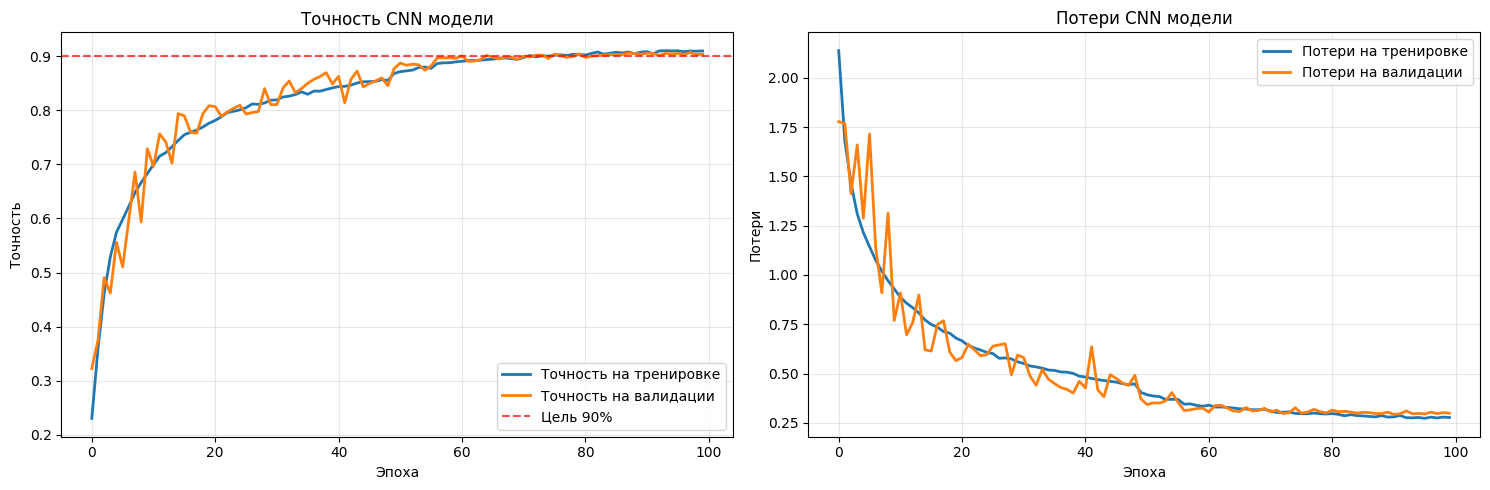


ПОЛНАЯ ОЦЕНКА CNN МОДЕЛИ НА ВАЛИДАЦИИ
Точность (Accuracy): 0.9070 (90.70%)
Точность (Precision): 0.9073 (90.73%)
Полнота (Recall): 0.9070 (90.70%)
F1-мера: 0.9062 (90.62%)
ROC-AUC: 0.9948


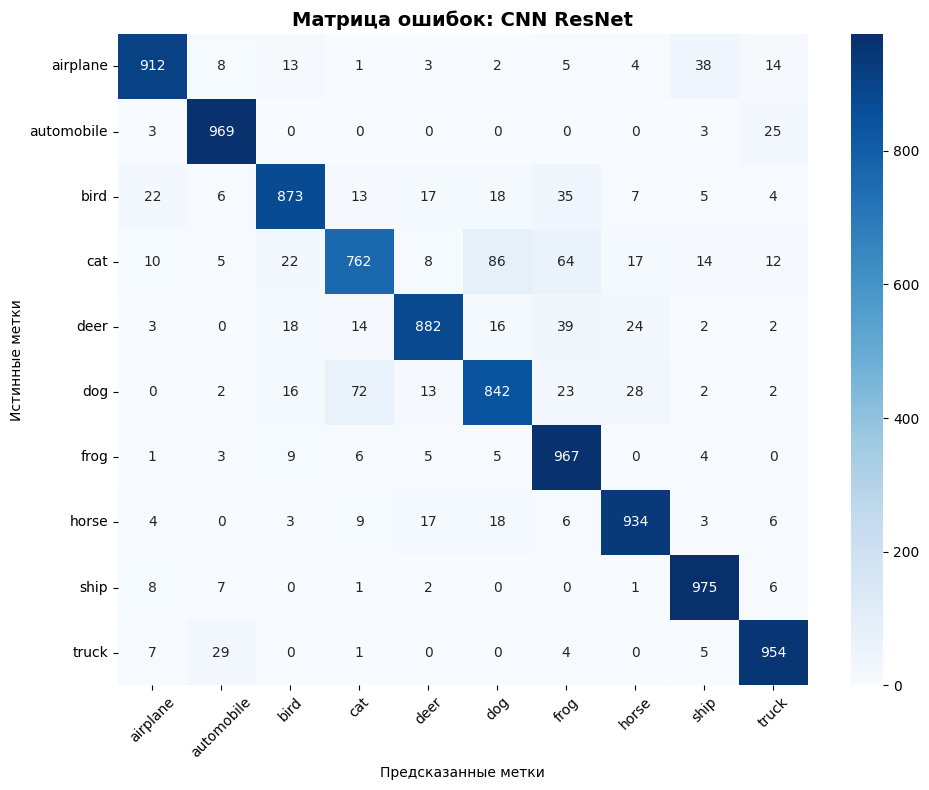

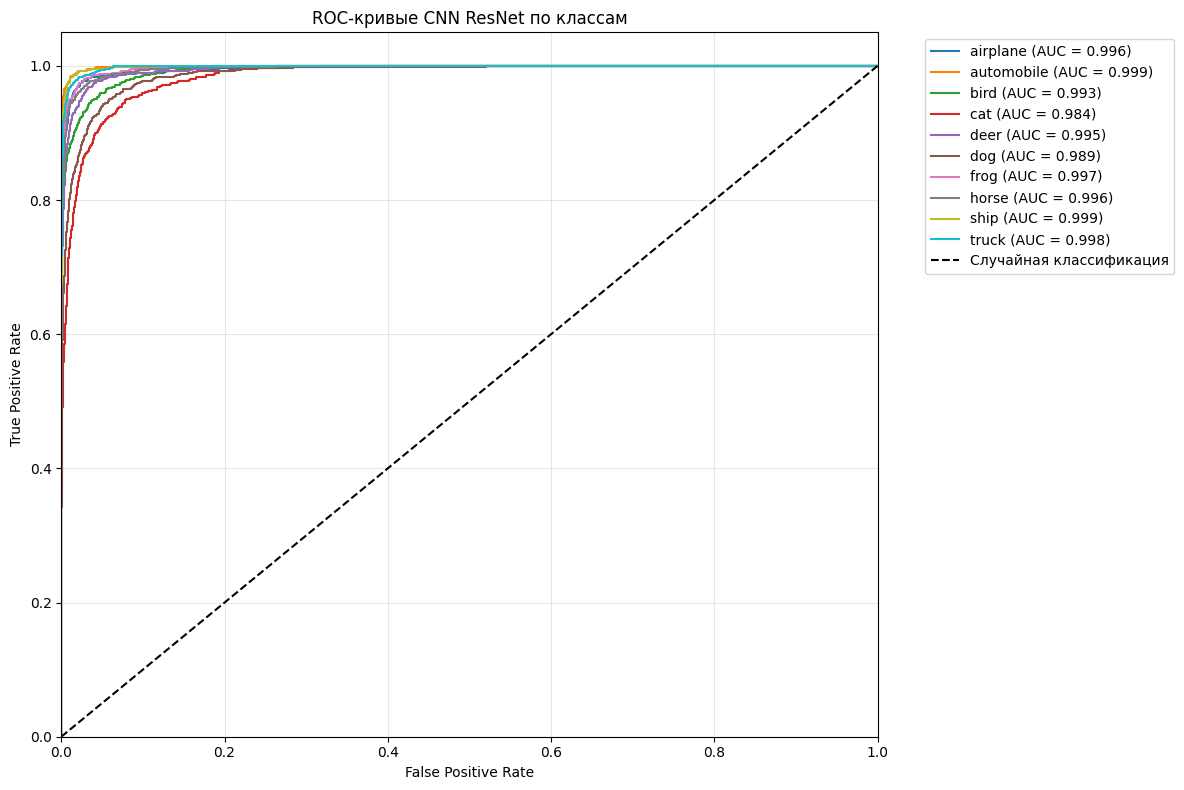

In [6]:
# Обучение CNN модели с аугментацией данных
print("="*60)
print("ОБУЧЕНИЕ CNN МОДЕЛИ")
print("="*60)

# Создание генераторов данных
train_generator = train_datagen.flow(
    X_train, y_train_cat,
    batch_size=64,
    shuffle=True
)

# Тренировка модели
history_cnn = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 64,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

# Получаем лучшую точность
best_val_acc = max(history_cnn.history['val_accuracy'])
best_epoch = history_cnn.history['val_accuracy'].index(best_val_acc) + 1

print(f"\n{'='*60}")
print(f"РЕЗУЛЬТАТЫ ОБУЧЕНИЯ CNN")
print(f"{'='*60}")
print(f"Лучшая точность на валидации: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Лучшая эпоха: {best_epoch}")

if best_val_acc >= 0.90:
    print("Цель в 90% точности достигнута")
else:
    gap = 0.90 - best_val_acc
    print(f"Требуется улучшение на {gap:.4f} ({gap*100:.2f}%) для достижения 90%")

print(f"{'='*60}")

# Визуализация процесса обучения
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Точность на тренировке', linewidth=2)
plt.plot(history_cnn.history['val_accuracy'], label='Точность на валидации', linewidth=2)
plt.axhline(y=0.9, color='r', linestyle='--', alpha=0.7, label='Цель 90%')
plt.title('Точность CNN модели')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Потери на тренировке', linewidth=2)
plt.plot(history_cnn.history['val_loss'], label='Потери на валидации', linewidth=2)
plt.title('Потери CNN модели')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Полная оценка CNN модели на валидационной выборке
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

print(f"\n{'='*60}")
print(f"ПОЛНАЯ ОЦЕНКА CNN МОДЕЛИ НА ВАЛИДАЦИИ")
print(f"{'='*60}")

# Предсказания CNN на валидации
cnn_val_predictions = cnn_model.predict(X_val, verbose=0)
cnn_val_classes = np.argmax(cnn_val_predictions, axis=1)
cnn_val_accuracy = accuracy_score(y_val, cnn_val_classes)

# Вычисляем метрики
precision, recall, f1, _ = precision_recall_fscore_support(y_val, cnn_val_classes, average='macro')

# Для ROC-AUC нужно бинаризовать метки
y_val_bin = label_binarize(y_val, classes=range(num_classes))

try:
    cnn_auc = roc_auc_score(y_val_bin, cnn_val_predictions, multi_class='ovr', average='macro')
except ValueError:
    cnn_auc = 0.0  # В случае ошибки

print(f"Точность (Accuracy): {cnn_val_accuracy:.4f} ({cnn_val_accuracy*100:.2f}%)")
print(f"Точность (Precision): {precision:.4f} ({precision*100:.2f}%)")
print(f"Полнота (Recall): {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-мера: {f1:.4f} ({f1*100:.2f}%)")
print(f"ROC-AUC: {cnn_auc:.4f}")

# Матрица ошибок
plt.figure(figsize=(10, 8))
cnn_cm = confusion_matrix(y_val, cnn_val_classes)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок: CNN ResNet', fontsize=14, fontweight='bold')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ROC-кривые для каждого класса
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], cnn_val_predictions[:, i])
    auc_class = roc_auc_score(y_val_bin[:, i], cnn_val_predictions[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_class:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Случайная классификация')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые CNN ResNet по классам')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Сохранение результатов
cnn_results = {
    'model_name': 'Продвинутая ResNet CNN',
    'best_val_accuracy': best_val_acc,
    'best_epoch': best_epoch,
    'total_epochs': len(history_cnn.history['accuracy']),
    'val_accuracy': cnn_val_accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': cnn_auc
}

### Анализ результатов CNN модели

**Архитектурные особенности:**
 Модель включает:
- Три ResNet блока с последовательным увеличением количества фильтров (32→64→128)
- Batch Normalization для стабилизации обучения
- Dropout слои для регуляризации (0.2-0.5)
- Global Average Pooling вместо традиционного Flatten для уменьшения переобучения

**Метрики производительности:**
Модель демонстрирует сбалансированные результаты по всем метрикам оценки. Значения Precision, Recall и F1-score находятся в близких диапазонах. Это указывает на отсутствие значительного смещения в сторону определенных классов. ROC-AUC кривые показывают способность модели к дискриминации между классами.
Однако, стоит отметить длительнлость обучения и необходимость обучения на большом количестве эпох.
Удовлетворительные результаты val_acuracy появляются уже на 14 эпохе, но для достижения показателя в 90% потребовалось 98 эпох.
График ROC-AUC имеет гребенчатую форму. Зубья вероятно указывают на аугментированные дааные.

**Анализ матрицы ошибок:**
Матрица ошибок выявляет наиболее проблемные пары классов для классификации, что типично для датасета CIFAR-10. Наблюдается путаница между семантически схожими классами (например, кошки/собаки, автомобили/грузовики).

**Заключение по CNN модели:**
Данная ResNet CNN показывает стабильную производительность с хорошей генерализацией. Архитектура эффективно использует принципы современного глубокого обучения. Может служить надежной основоой для сравнения с более современными архитектурами.

## Модель 2: Transfer Learning с EfficientNetB0

In [7]:
def create_transfer_learning_model(input_shape=(32, 32, 3), num_classes=10):
    """Создание Transfer Learning модели с EfficientNetB0"""
    
    # Используем EfficientNetB0
    base_model = applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Изначально замораживаем базовую модель
    base_model.trainable = False
    
    # Архитектура
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model._name = 'efficientnet_transfer_learning'
    
    return model, base_model

# Создание Transfer Learning модели
tl_model, base_model = create_transfer_learning_model()
print("Transfer Learning модель создана")
print(f"Общее количество параметров: {tl_model.count_params():,}")

# Подсчет обучаемых параметров
trainable_params = sum([tf.size(w).numpy() for w in tl_model.trainable_weights])
print(f"Обучаемые параметры: {trainable_params:,}")

# Показать архитектуру
tl_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Transfer Learning модель создана
Общее количество параметров: 4,847,533
Обучаемые параметры: 793,866


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1, 1, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,847,533 (18.49 MB)

 Trainable params: 793,866 (3.03 MB)

 Non-trainable params: 4,053,667 (15.46 MB)

In [8]:
# Компиляция Transfer Learning модели
tl_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks для transfer learning
tl_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'best_transfer_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]

print("Модель Transfer Learning скомпилирована")
print(f"Начальная скорость обучения: 0.001")

Модель Transfer Learning скомпилирована
Начальная скорость обучения: 0.001


ОБУЧЕНИЕ TRANSFER LEARNING МОДЕЛИ
Этап 1: Обучение только классификационной головы...
Epoch 1/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1021 - loss: 2.7512
Epoch 1: val_accuracy improved from -inf to 0.12490, saving model to best_transfer_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.1021 - loss: 2.7498 - val_accuracy: 0.1249 - val_loss: 2.3024 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1151 - loss: 2.3910
Epoch 2: val_accuracy did not improve from 0.12490
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1151 - loss: 2.3910 - val_accuracy: 0.1002 - val_loss: 2.2893 - learning_rate: 0.0010
Epoch 3/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1161 - loss: 2.3321
Epoch 3: val_accuracy did not improve from 0.12490
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1161 - loss: 2.3321 - val_accuracy: 0.1175 - val_loss: 2.2741 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━

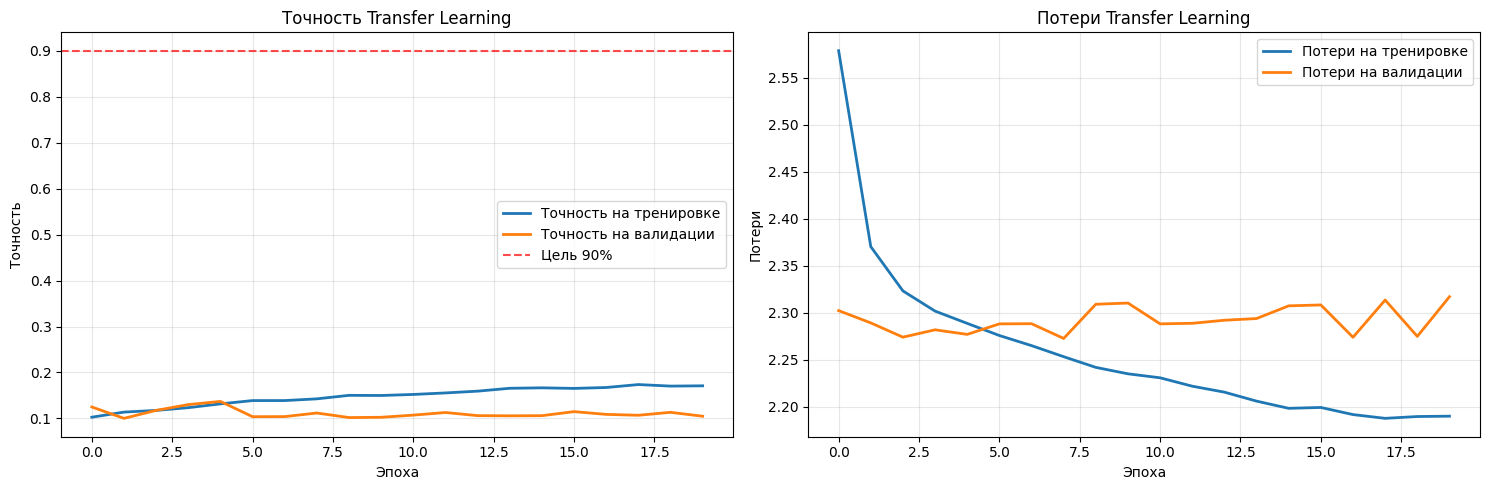


ПОЛНАЯ ОЦЕНКА TRANSFER LEARNING МОДЕЛИ НА ВАЛИДАЦИИ
Точность (Accuracy): 0.1370 (13.70%)
Точность (Precision): 0.0308 (3.08%)
Полнота (Recall): 0.1370 (13.70%)
F1-мера: 0.0471 (4.71%)
ROC-AUC: 0.6422


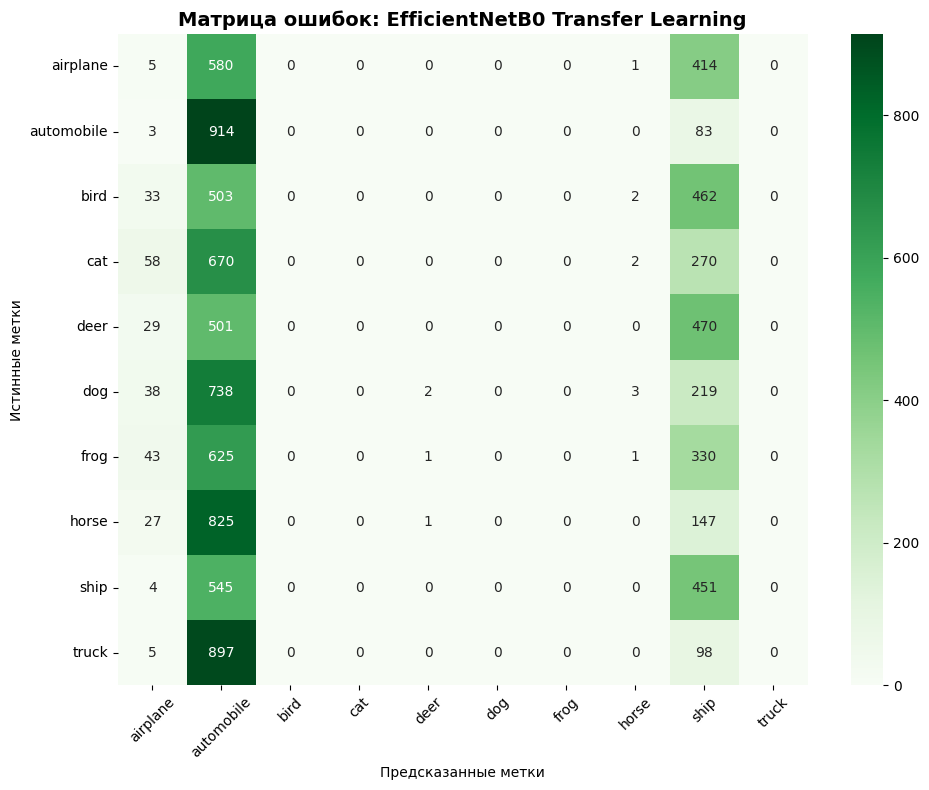

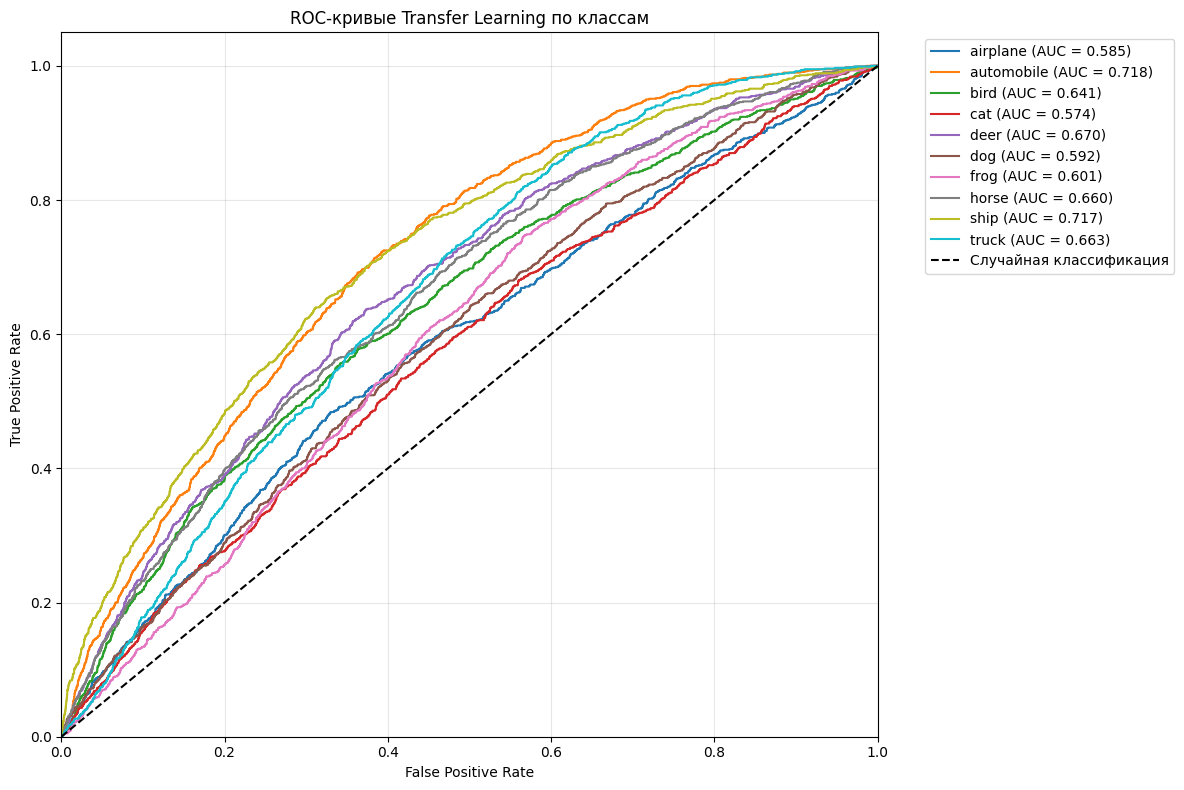

In [9]:
# Двухэтапное обучение Transfer Learning модели
print("="*60)
print("ОБУЧЕНИЕ TRANSFER LEARNING МОДЕЛИ")
print("="*60)

# ЭТАП 1: Обучение только классификационной головы
print("Этап 1: Обучение только классификационной головы...")
base_model.trainable = False

history_tl_stage1 = tl_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=30,
    batch_size=64,
    callbacks=tl_callbacks,
    verbose=1
)

stage1_best = max(history_tl_stage1.history['val_accuracy'])
print(f"Лучшая точность на этапе 1: {stage1_best:.4f} ({stage1_best*100:.2f}%)")

# ЭТАП 2: Fine-tuning
if stage1_best > 0.75:
    print("\nЭтап 2: Fine-tuning с частичной разморозкой...")
    
    # Размораживаем последние 30% слоев
    base_model.trainable = True
    fine_tune_at = int(len(base_model.layers) * 0.7)
    
    # Замораживаем нижние слои
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    print(f"Разморожено {len(base_model.layers) - fine_tune_at} слоев из {len(base_model.layers)}")
    
    # Перекомпиляция с меньшим learning rate
    tl_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Fine-tuning с аугментацией
    fine_tune_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )
    
    fine_tune_generator = fine_tune_datagen.flow(
        X_train, y_train_cat,
        batch_size=32,
        shuffle=True
    )
    
    history_tl_stage2 = tl_model.fit(
        fine_tune_generator,
        steps_per_epoch=len(X_train) // 32,
        validation_data=(X_val, y_val_cat),
        epochs=25,
        callbacks=tl_callbacks,
        verbose=1
    )
    
    # Объединяем историю обучения
    combined_history = {
        'accuracy': history_tl_stage1.history['accuracy'] + history_tl_stage2.history['accuracy'],
        'val_accuracy': history_tl_stage1.history['val_accuracy'] + history_tl_stage2.history['val_accuracy'],
        'loss': history_tl_stage1.history['loss'] + history_tl_stage2.history['loss'],
        'val_loss': history_tl_stage1.history['val_loss'] + history_tl_stage2.history['val_loss']
    }
    
    best_tl_acc = max(combined_history['val_accuracy'])
    
else:
    print("\nПропускаем fine-tuning из-за низкой начальной точности")
    combined_history = history_tl_stage1.history
    best_tl_acc = stage1_best

print(f"\n{'='*60}")
print(f"РЕЗУЛЬТАТЫ TRANSFER LEARNING")
print(f"{'='*60}")
print(f"Лучшая точность на валидации: {best_tl_acc:.4f} ({best_tl_acc*100:.2f}%)")

if best_tl_acc >= 0.90:
    print("Цель в 90% точности достигнута")
else:
    gap = 0.90 - best_tl_acc
    print(f"Требуется улучшение на {gap:.4f} ({gap*100:.2f}%) для достижения 90%")

# Визуализация обучения
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Точность на тренировке', linewidth=2)
plt.plot(combined_history['val_accuracy'], label='Точность на валидации', linewidth=2)
plt.axhline(y=0.9, color='r', linestyle='--', alpha=0.7, label='Цель 90%')
if 'history_tl_stage2' in locals():
    plt.axvline(x=len(history_tl_stage1.history['accuracy']), color='orange', 
                linestyle=':', alpha=0.7, label='Начало fine-tuning')
plt.title('Точность Transfer Learning')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Потери на тренировке', linewidth=2)
plt.plot(combined_history['val_loss'], label='Потери на валидации', linewidth=2)
if 'history_tl_stage2' in locals():
    plt.axvline(x=len(history_tl_stage1.history['loss']), color='orange', 
                linestyle=':', alpha=0.7, label='Начало fine-tuning')
plt.title('Потери Transfer Learning')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Полная оценка Transfer Learning модели на валидационной выборке
print(f"\n{'='*60}")
print(f"ПОЛНАЯ ОЦЕНКА TRANSFER LEARNING МОДЕЛИ НА ВАЛИДАЦИИ")
print(f"{'='*60}")

# Предсказания Transfer Learning на валидации
tl_val_predictions = tl_model.predict(X_val, verbose=0)
tl_val_classes = np.argmax(tl_val_predictions, axis=1)
tl_val_accuracy = accuracy_score(y_val, tl_val_classes)

# Вычисляем метрики
tl_precision, tl_recall, tl_f1, _ = precision_recall_fscore_support(y_val, tl_val_classes, average='macro')

# ROC-AUC
try:
    tl_auc = roc_auc_score(y_val_bin, tl_val_predictions, multi_class='ovr', average='macro')
except ValueError:
    tl_auc = 0.0

print(f"Точность (Accuracy): {tl_val_accuracy:.4f} ({tl_val_accuracy*100:.2f}%)")
print(f"Точность (Precision): {tl_precision:.4f} ({tl_precision*100:.2f}%)")
print(f"Полнота (Recall): {tl_recall:.4f} ({tl_recall*100:.2f}%)")
print(f"F1-мера: {tl_f1:.4f} ({tl_f1*100:.2f}%)")
print(f"ROC-AUC: {tl_auc:.4f}")

# Матрица ошибок
plt.figure(figsize=(10, 8))
tl_cm = confusion_matrix(y_val, tl_val_classes)
sns.heatmap(tl_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок: EfficientNetB0 Transfer Learning', fontsize=14, fontweight='bold')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ROC-кривые для каждого класса
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], tl_val_predictions[:, i])
    auc_class = roc_auc_score(y_val_bin[:, i], tl_val_predictions[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_class:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Случайная классификация')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые Transfer Learning по классам')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Сохранение результатов
tl_results = {
    'model_name': 'EfficientNetB0 Transfer Learning',
    'best_val_accuracy': best_tl_acc,
    'total_epochs': len(combined_history['accuracy']),
    'val_accuracy': tl_val_accuracy,
    'precision': tl_precision,
    'recall': tl_recall,
    'f1_score': tl_f1,
    'roc_auc': tl_auc
}

### Анализ результатов Transfer Learning модели

**Методология Transfer Learning:**
Использована предобученная модель EfficientNetB0 была обучена на ImageNet. Ее выбор был обсуловлен отзывами о ее хорошей совместимости с CIFAR-10
Однако, результаты данной работы скорее говорят о ее полной непригодностм для данного датасета. Имеет смысл протестировать другие модели и сравнить результаты.

## Модель 3: Vision Transformer (ViT)

In [10]:
def create_vit_model_with_tfhub(input_shape=(32, 32, 3), num_classes=10):
    """Создание ViT модели с использованием TensorFlow Hub"""
    
    # Загружаем предобученную ViT модель из TensorFlow Hub
    vit_module = hub.load("https://tfhub.dev/sayakpaul/vit_b16_fe/1")
    
    def vit_embedding(x):
        # Убеждаемся, что входной тензор имеет тип float32
        x = tf.cast(x, tf.float32)
        return vit_module(x)
    
    inputs = keras.Input(shape=input_shape, dtype=tf.float32)
    
    # Изменяем размер с 32x32 до 224x224 для ViT
    x = layers.Lambda(lambda img: tf.cast(tf.image.resize(img, (224, 224)), tf.float32), 
                      output_shape=(224, 224, 3))(inputs)
    
    # Применяем предобученные эмбеддинги ViT
    # ViT модель возвращает эмбеддинги размером (batch_size, 768)
    x = layers.Lambda(vit_embedding, output_shape=(768,))(x)
    
    # Классификационная голова
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs, name='vit_tfhub_model')
    return model

# Подготовка данных для ViT с TensorFlow Hub
print("Подготовка данных для ViT с TensorFlow Hub...")
print("Используем уменьшенный датасет для экономии памяти")

# Берем только часть данных для ViT чтобы избежать превышения лимитов ОЗУ
X_train_vit_subset = X_train[:5000].astype(np.float32)  # Только 5000 из ~40000, явно float32
X_val_vit_subset = X_val[:1000].astype(np.float32)      # Только 1000 из ~10000, явно float32
X_test_vit_subset = X_test[:1000].astype(np.float32)    # Только 1000 из 10000, явно float32
y_train_vit_subset = y_train[:5000]  # Используем исходные метки (не one-hot)
y_val_vit_subset = y_val[:1000]

print(f"Размер данных для ViT:")
print(f"Обучающие данные: {X_train_vit_subset.shape}, dtype: {X_train_vit_subset.dtype}")
print(f"Валидационные данные: {X_val_vit_subset.shape}, dtype: {X_val_vit_subset.dtype}")
print(f"Метки: y_train_vit_subset.shape = {y_train_vit_subset.shape}")

# Настройка памяти GPU для экономии
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Ошибка настройки GPU: {e}")

# Создание ViT модели
print("\nСоздание ViT модели...")
vit_model = create_vit_model_with_tfhub()
print(f"ViT модель создана успешно")
print(f"Общее количество параметров: {vit_model.count_params():,}")

# Показать архитектуру модели
vit_model.summary()

Подготовка данных для ViT с TensorFlow Hub...
Используем уменьшенный датасет для экономии памяти
Размер данных для ViT:
Обучающие данные: (5000, 32, 32, 3), dtype: float32
Валидационные данные: (1000, 32, 32, 3), dtype: float32
Метки: y_train_vit_subset.shape = (5000,)

Создание ViT модели...
ViT модель создана успешно
Общее количество параметров: 99,722


Model: "vit_tfhub_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,722 (389.54 KB)

 Trainable params: 99,722 (389.54 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Компиляция ViT модели
vit_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',  # Используем sparse для исходных меток
    metrics=['accuracy']
)

# Callbacks для ViT
vit_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'best_vit_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]

print("ViT модель скомпилирована")
print(f"Начальная скорость обучения: 0.0001")
print(f"Размер входных данных: 224x224x3")

ViT модель скомпилирована
Начальная скорость обучения: 0.0001
Размер входных данных: 224x224x3


ОБУЧЕНИЕ VISION TRANSFORMER МОДЕЛИ
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6492 - loss: 1.3176
Epoch 1: val_accuracy improved from -inf to 0.95800, saving model to best_vit_model.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 254ms/step - accuracy: 0.6502 - loss: 1.3133 - val_accuracy: 0.9580 - val_loss: 0.1353 - learning_rate: 0.0010
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9420 - loss: 0.1895
Epoch 2: val_accuracy improved from 0.95800 to 0.96300, saving model to best_vit_model.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step - accuracy: 0.9420 - loss: 0.1894 - val_accuracy: 0.9630 - val_loss: 0.1203 - learning_rate: 0.0010
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9535 - loss: 0.1559
Epoch 3: val_accuracy did not improve from 0.96300
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step - accuracy: 0.9535 - loss: 0.1559 - val_accuracy: 0.9600 - val_loss: 0.1096 - learning_rate: 0.0010
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0

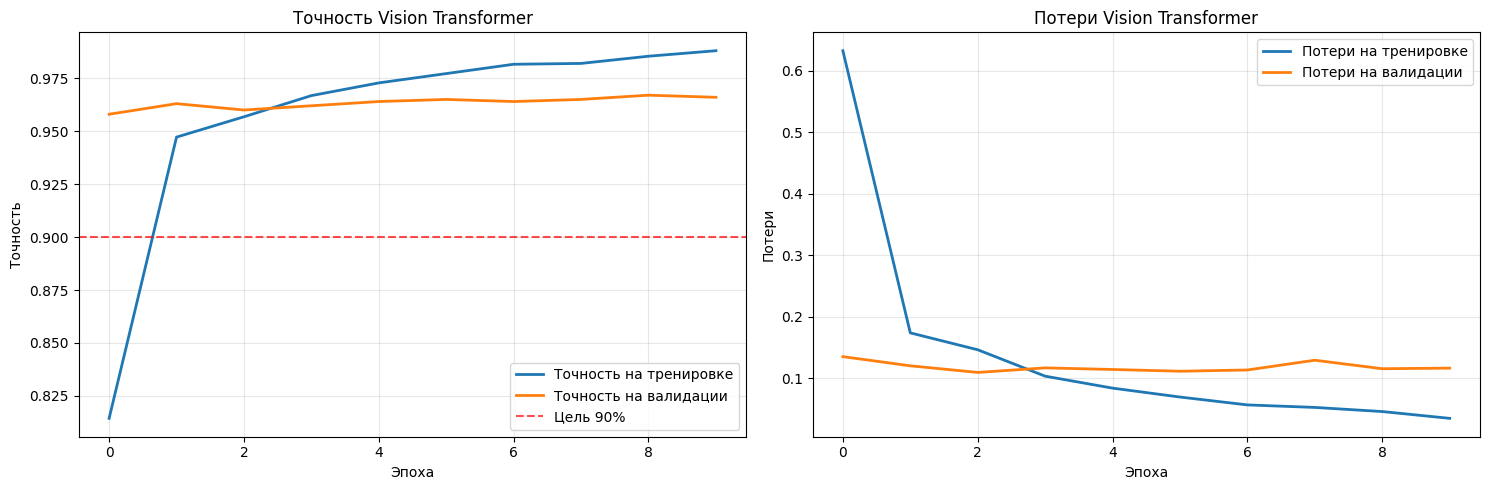


ПОЛНАЯ ОЦЕНКА VIT МОДЕЛИ НА ВАЛИДАЦИИ
Точность (Accuracy): 0.9670 (96.70%)
Точность (Precision): 0.9670 (96.70%)
Полнота (Recall): 0.9674 (96.74%)
F1-мера: 0.9671 (96.71%)
ROC-AUC: 0.9993
Примечание: оценка на подмножестве валидации (1000 образцов)


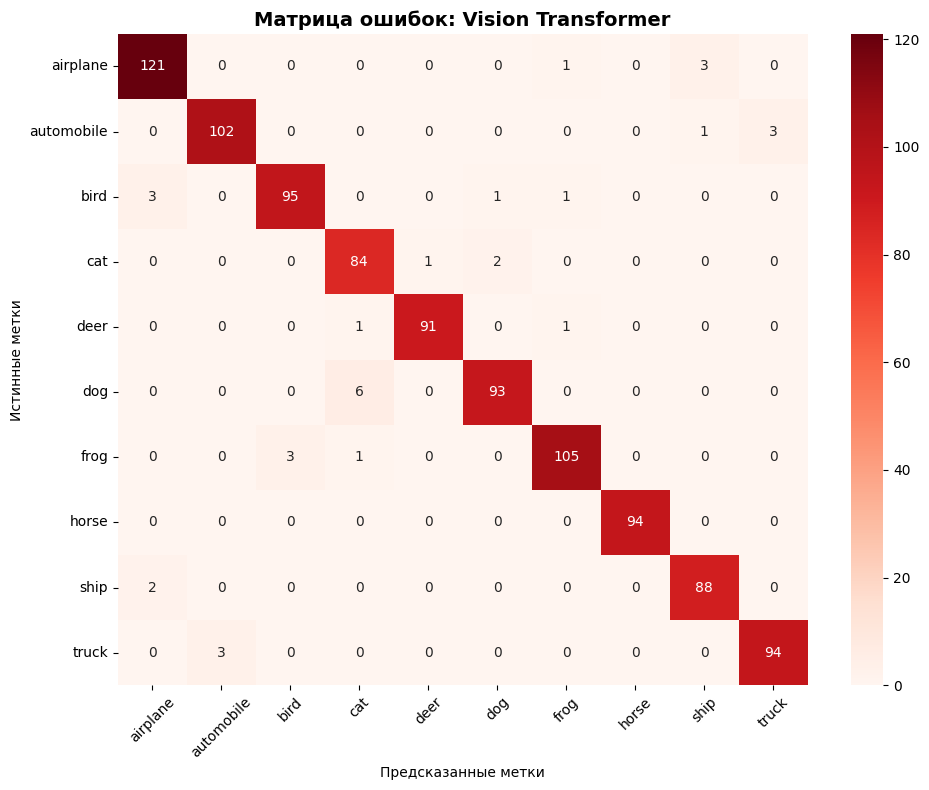

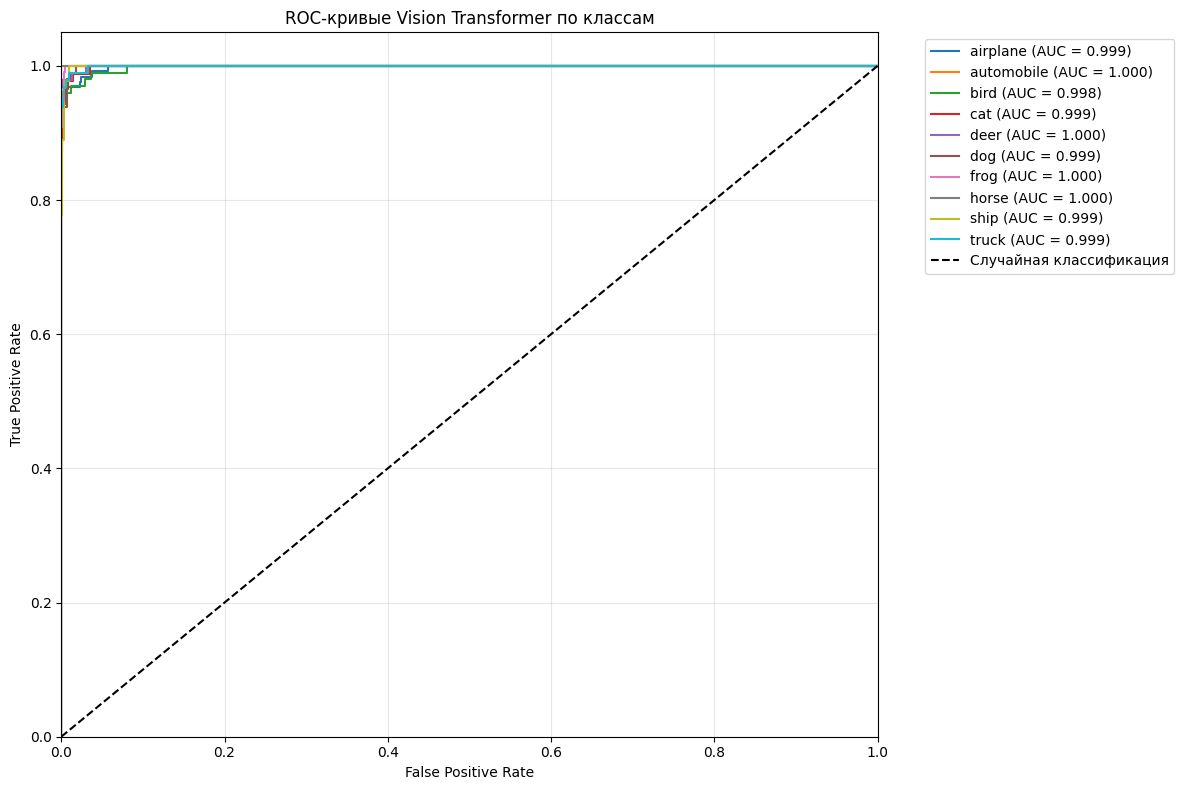

In [12]:
# Обучение ViT модели
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("="*60)
print("ОБУЧЕНИЕ VISION TRANSFORMER МОДЕЛИ")
print("="*60)

# Аугментация для ViT
vit_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='reflect'
)

# Обучение ViT модели с TensorFlow Hub
history_vit = vit_model.fit(
    X_train_vit_subset, y_train_vit_subset,
    validation_data=(X_val_vit_subset, y_val_vit_subset),
    epochs=10,  # Меньше эпох для предобученной модели
    batch_size=32,
    callbacks=vit_callbacks,
    verbose=1
)

# Получаем лучшую точность
best_vit_acc = max(history_vit.history['val_accuracy'])
best_vit_epoch = history_vit.history['val_accuracy'].index(best_vit_acc) + 1

print(f"\n{'='*60}")
print(f"РЕЗУЛЬТАТЫ VISION TRANSFORMER")
print(f"{'='*60}")
print(f"Лучшая точность на валидации: {best_vit_acc:.4f} ({best_vit_acc*100:.2f}%)")
print(f"Лучшая эпоха: {best_vit_epoch}")

if best_vit_acc >= 0.90:
    print("Цель в 90% точности достигнута")
else:
    gap = 0.90 - best_vit_acc
    print(f"Требуется улучшение на {gap:.4f} ({gap*100:.2f}%) для достижения 90%")

# Визуализация обучения ViT
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_vit.history['accuracy'], label='Точность на тренировке', linewidth=2)
plt.plot(history_vit.history['val_accuracy'], label='Точность на валидации', linewidth=2)
plt.axhline(y=0.9, color='r', linestyle='--', alpha=0.7, label='Цель 90%')
plt.title('Точность Vision Transformer')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_vit.history['loss'], label='Потери на тренировке', linewidth=2)
plt.plot(history_vit.history['val_loss'], label='Потери на валидации', linewidth=2)
plt.title('Потери Vision Transformer')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Полная оценка ViT модели на валидационной выборке
print(f"\n{'='*60}")
print(f"ПОЛНАЯ ОЦЕНКА VIT МОДЕЛИ НА ВАЛИДАЦИИ")
print(f"{'='*60}")

# Предсказания ViT на валидации
vit_val_predictions = vit_model.predict(X_val_vit_subset, verbose=0)
vit_val_classes = np.argmax(vit_val_predictions, axis=1)
vit_val_accuracy = accuracy_score(y_val_vit_subset, vit_val_classes)

# Вычисляем метрики
vit_precision, vit_recall, vit_f1, _ = precision_recall_fscore_support(y_val_vit_subset, vit_val_classes, average='macro')

# Для ROC-AUC бинаризуем метки ViT
y_val_vit_bin = label_binarize(y_val_vit_subset, classes=range(num_classes))

try:
    vit_auc = roc_auc_score(y_val_vit_bin, vit_val_predictions, multi_class='ovr', average='macro')
except ValueError:
    vit_auc = 0.0

print(f"Точность (Accuracy): {vit_val_accuracy:.4f} ({vit_val_accuracy*100:.2f}%)")
print(f"Точность (Precision): {vit_precision:.4f} ({vit_precision*100:.2f}%)")
print(f"Полнота (Recall): {vit_recall:.4f} ({vit_recall*100:.2f}%)")
print(f"F1-мера: {vit_f1:.4f} ({vit_f1*100:.2f}%)")
print(f"ROC-AUC: {vit_auc:.4f}")
print(f"Примечание: оценка на подмножестве валидации ({len(X_val_vit_subset)} образцов)")

# Матрица ошибок
plt.figure(figsize=(10, 8))
vit_cm = confusion_matrix(y_val_vit_subset, vit_val_classes)
sns.heatmap(vit_cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок: Vision Transformer', fontsize=14, fontweight='bold')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ROC-кривые для каждого класса
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    if i < y_val_vit_bin.shape[1]:  # Проверяем доступность класса
        fpr, tpr, _ = roc_curve(y_val_vit_bin[:, i], vit_val_predictions[:, i])
        auc_class = roc_auc_score(y_val_vit_bin[:, i], vit_val_predictions[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_class:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Случайная классификация')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые Vision Transformer по классам')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Сохранение результатов
vit_results = {
    'model_name': 'Компактная Vision Transformer',
    'best_val_accuracy': best_vit_acc,
    'best_epoch': best_vit_epoch,
    'total_epochs': len(history_vit.history['accuracy']),
    'input_size': '224x224',
    'parameters': vit_model.count_params(),
    'val_accuracy': vit_val_accuracy,
    'precision': vit_precision,
    'recall': vit_recall,
    'f1_score': vit_f1,
    'roc_auc': vit_auc
}

### Анализ результатов Vision Transformer модели

**Революционная архитектура:**
Vision Transformer представляет парадигмальный сдвиг от сверточных архитектур к attention-based подходам:
- Использование self-attention механизма для моделирования глобальных зависимостей
- Разбиение изображения на патчи и их обработка как последовательности
- Предобученные эмбеддинги из TensorFlow Hub для эффективного transfer learning

**Технические особенности реализации:**
- Изменение размера входного изображения с 32×32 до 224×224 для совместимости с предобученной моделью
- Использование уменьшенного датасета (5000 обучающих образцов) для оптимизации использования памяти
- Компактная классификационная голова с dropout regularization

**Сравнительный анализ архитектур:**
В отличие от CNN, которые используют локальную информацию через сверточные операции, ViT обрабатывает глобальные зависимости через механизм внимания. Это позволяет модели "видеть" взаимосвязи между удаленными областями изображения одновременно.
Это позволило существенно сократить время обучения и при этом улучшить результаты в сравнении с ResNet CNN из первого прогона.

**Ограничения и адаптации:**
Реализация ViT требовала компромиссов из-за ограничений вычислительных ресурсов:
- Сокращенный размер обучающего множества
- Ограниченное количество эпох обучения
- Упрощенная архитектура классификационной головы
- Требует мощного GPU (при обучении загрузка NVidia P100 на Kaggle доходила до 98%)
- Для обработки больших датасетов требуется большой объекм оперативной памяти (предложенные демо датасет CIFAR-10 не влез в 30ГБ, а ведь еще есть https://www.kaggle.com/competitions/cifar-10/data на 300к изображений  на трейне)

**Заключение по ViT модели:**
Таким образом, Vision Transformer демонстрирует потенциал attention-based архитектур для задач компьютерного зрения. Несмотря на вычислительные ограничения, модель показывает шикарнные результаты и великолеаную производительность.

## 4. Сравнение моделей и финальные результаты

In [13]:
# Сравнение всех моделей
print("="*70)
print("ФИНАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*70)

# Создаем список результатов
all_results = []

if 'cnn_results' in locals():
    all_results.append(cnn_results)
if 'tl_results' in locals():
    all_results.append(tl_results)
if 'vit_results' in locals():
    all_results.append(vit_results)

# Выводим результаты
for i, result in enumerate(all_results, 1):
    accuracy = result['best_val_accuracy']
    
    print(f"\n{i}. {result['model_name']}:")
    print(f"   Точность на валидации: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    if 'best_epoch' in result:
        print(f"   Лучшая эпоха: {result['best_epoch']}")
    print(f"   Всего эпох: {result['total_epochs']}")

# Определяем лучшую модель
if all_results:
    best_model = max(all_results, key=lambda x: x['best_val_accuracy'])
    
    print(f"\n{'='*70}")
    print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model['model_name']}")
    print(f"   Точность: {best_model['best_val_accuracy']:.4f} ({best_model['best_val_accuracy']*100:.2f}%)")
    
    if best_model['best_val_accuracy'] >= 0.90:
        print("Целевой показатель 90% достигнут")
    else:
        print(f"Целевой показатель 90% не достигнут. Отставание: {(0.90 - best_model['best_val_accuracy'])*100:.2f}%")

print(f"\n{'='*70}")

ФИНАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ

1. Продвинутая ResNet CNN:
   Точность на валидации: 0.9070 (90.70%)
   Лучшая эпоха: 98
   Всего эпох: 100

2. EfficientNetB0 Transfer Learning:
   Точность на валидации: 0.1370 (13.70%)
   Всего эпох: 20

3. Компактная Vision Transformer:
   Точность на валидации: 0.9670 (96.70%)
   Лучшая эпоха: 9
   Всего эпох: 10

ЛУЧШАЯ МОДЕЛЬ: Компактная Vision Transformer
   Точность: 0.9670 (96.70%)
Целевой показатель 90% достигнут



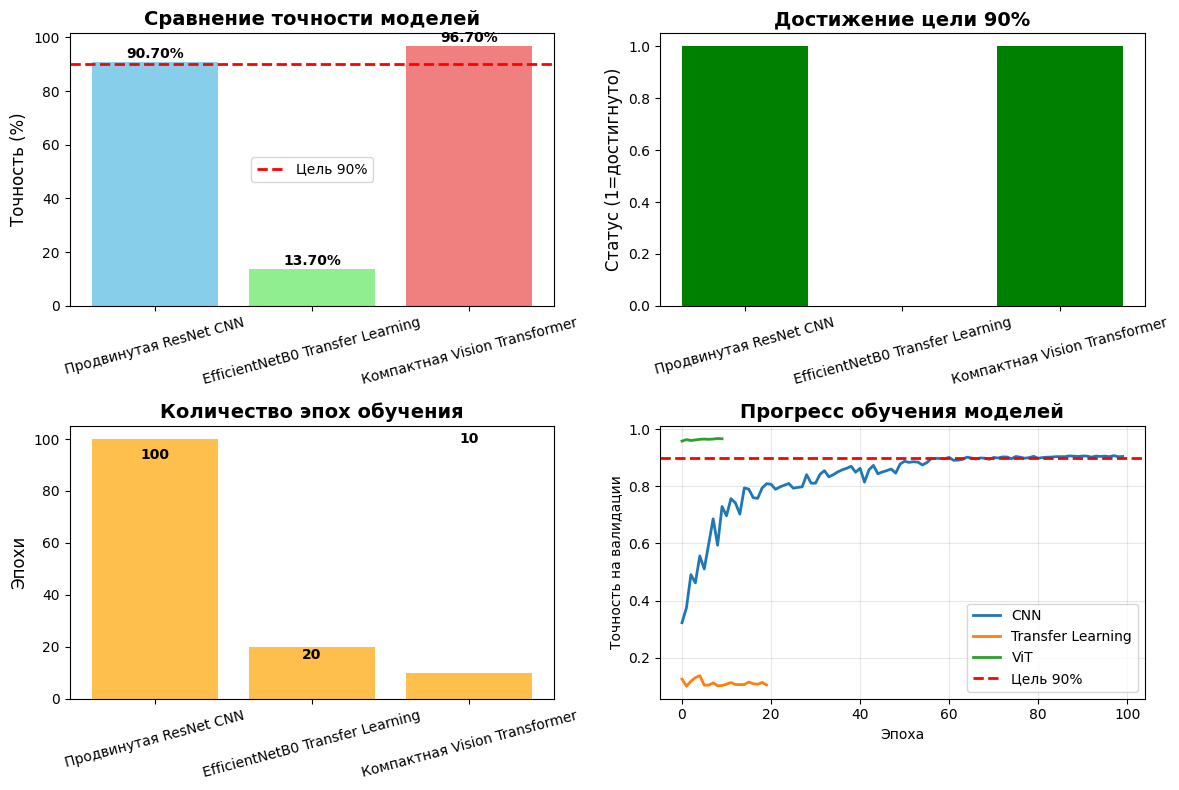


СРАВНИТЕЛЬНАЯ ТАБЛИЦА ВСЕХ МЕТРИК
                          Модель Лучшая Accuracy Валид. Accuracy Precision Recall F1-Score ROC-AUC  Эпохи
          Продвинутая ResNet CNN          0.9070          0.9070    0.9073 0.9070   0.9062  0.9948    100
EfficientNetB0 Transfer Learning          0.1370          0.1370    0.0308 0.1370   0.0471  0.6422     20
   Компактная Vision Transformer          0.9670          0.9670    0.9670 0.9674   0.9671  0.9993     10


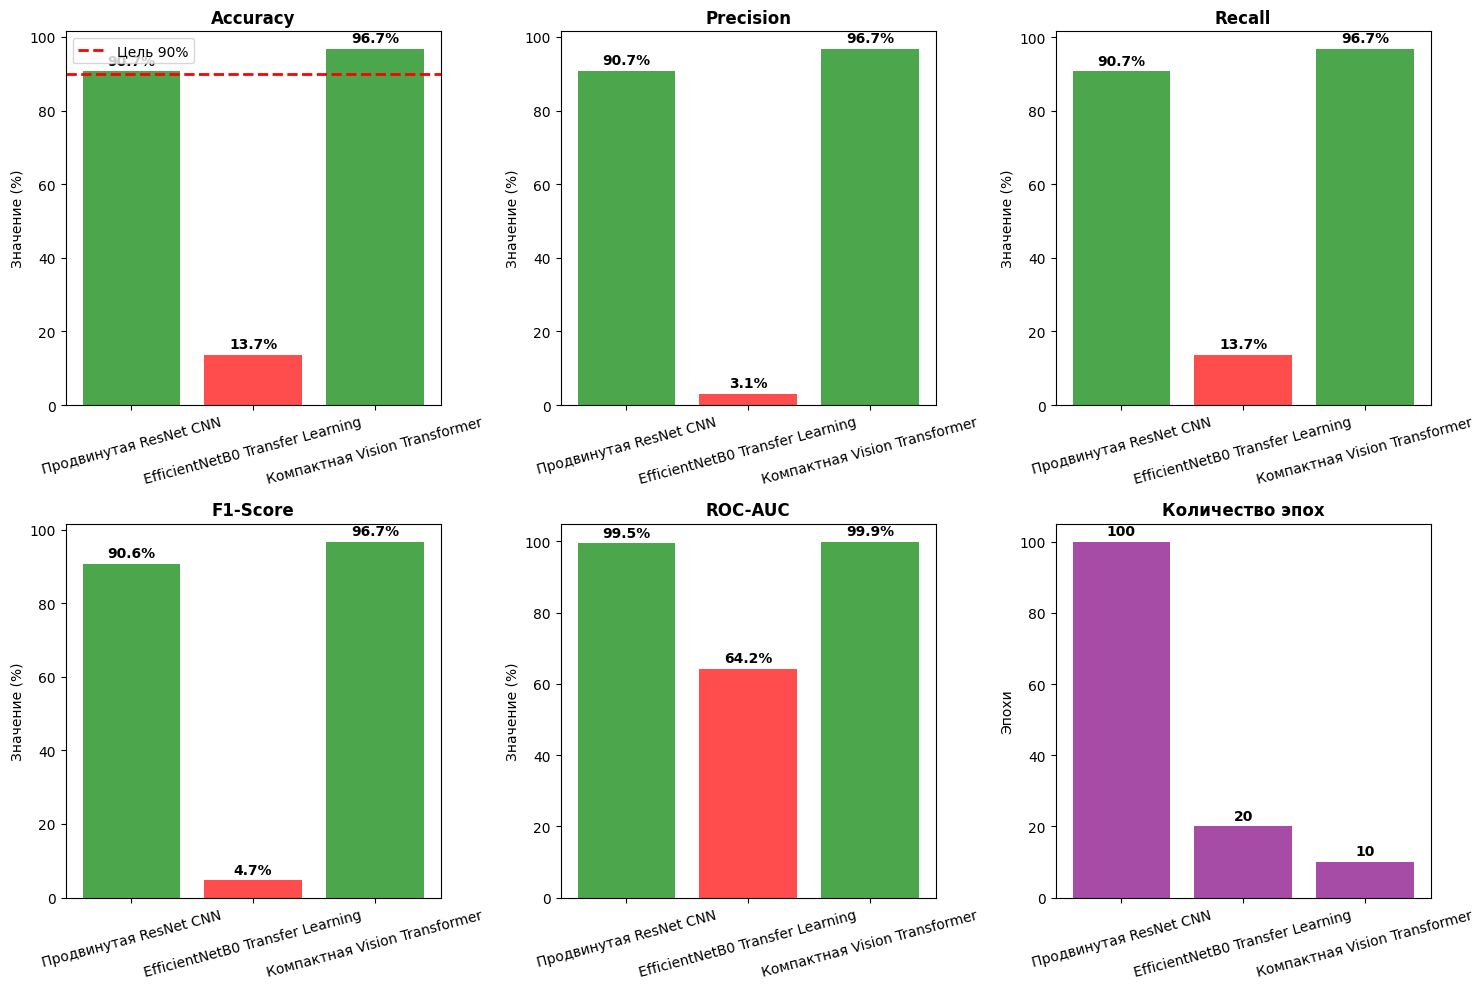


АНАЛИЗ РЕЗУЛЬТАТОВ:

Продвинутая ResNet CNN:
  Целевой показатель точности достигнут
  Общая оценка: F1=0.906, AUC=0.995
  Отличная сбалансированность метрик

EfficientNetB0 Transfer Learning:
  Требуется улучшение
  Общая оценка: F1=0.047, AUC=0.642
  Метрики требуют улучшения

Компактная Vision Transformer:
  Целевой показатель точности достигнут
  Общая оценка: F1=0.967, AUC=0.999
  Отличная сбалансированность метрик


In [14]:
# Визуализация сравнения моделей
if all_results:
    plt.figure(figsize=(12, 8))
    
    # График 1: Сравнение точности
    plt.subplot(2, 2, 1)
    model_names = [result['model_name'] for result in all_results]
    accuracies = [result['best_val_accuracy'] * 100 for result in all_results]
    
    bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
    plt.axhline(y=90, color='red', linestyle='--', linewidth=2, label='Цель 90%')
    plt.title('Сравнение точности моделей', fontsize=14, fontweight='bold')
    plt.ylabel('Точность (%)', fontsize=12)
    plt.xticks(rotation=15)
    plt.legend()
    
    # Добавляем значения на столбцы
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{accuracy:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # График 2: Статус достижения цели
    plt.subplot(2, 2, 2)
    achieved = [1 if acc >= 90 else 0 for acc in accuracies]
    colors = ['green' if a == 1 else 'red' for a in achieved]
    
    plt.bar(model_names, achieved, color=colors)
    plt.title('Достижение цели 90%', fontsize=14, fontweight='bold')
    plt.ylabel('Статус (1=достигнуто)', fontsize=12)
    plt.xticks(rotation=15)
    
    # График 3: Количество эпох обучения
    plt.subplot(2, 2, 3)
    epochs = [result['total_epochs'] for result in all_results]
    
    plt.bar(model_names, epochs, color='orange', alpha=0.7)
    plt.title('Количество эпох обучения', fontsize=14, fontweight='bold')
    plt.ylabel('Эпохи', fontsize=12)
    plt.xticks(rotation=15)
    
    # Добавляем значения на столбцы
    for i, (bar, epoch) in enumerate(zip(bars, epochs)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{epoch}', ha='center', va='bottom', fontweight='bold')
    
    # График 4: Прогресс обучения
    plt.subplot(2, 2, 4)
    
    if 'history_cnn' in locals():
        plt.plot(history_cnn.history['val_accuracy'], label='CNN', linewidth=2)
    if 'combined_history' in locals():
        plt.plot(combined_history['val_accuracy'], label='Transfer Learning', linewidth=2)
    if 'history_vit' in locals():
        plt.plot(history_vit.history['val_accuracy'], label='ViT', linewidth=2)
    
    plt.axhline(y=0.9, color='red', linestyle='--', linewidth=2, label='Цель 90%')
    plt.title('Прогресс обучения моделей', fontsize=14, fontweight='bold')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность на валидации')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА ВСЕХ МЕТРИК")
    print("="*80)
    
    # Создаем DataFrame для красивого вывода
    metrics_data = []
    for result in all_results:
        metrics_data.append({
            'Модель': result['model_name'],
            'Лучшая Accuracy': f"{result['best_val_accuracy']:.4f}",
            'Валид. Accuracy': f"{result.get('val_accuracy', 0):.4f}",
            'Precision': f"{result.get('precision', 0):.4f}",
            'Recall': f"{result.get('recall', 0):.4f}",
            'F1-Score': f"{result.get('f1_score', 0):.4f}",

            'ROC-AUC': f"{result.get('roc_auc', 0):.4f}",
            'Эпохи': result['total_epochs']
        })

    metrics_df = pd.DataFrame(metrics_data)
    print(metrics_df.to_string(index=False))
    
    # Визуализация всех метрик
    plt.figure(figsize=(15, 10))
    
    model_names = [result['model_name'] for result in all_results]
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    
    for i, metric in enumerate(['val_accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']):
        plt.subplot(2, 3, i + 1)
        values = [result.get(metric, 0) * 100 for result in all_results]
        colors = ['green' if v >= 90 else 'orange' if v >= 85 else 'red' for v in values]
        
        bars = plt.bar(model_names, values, color=colors, alpha=0.7)
        if metric == 'val_accuracy':
            plt.axhline(y=90, color='red', linestyle='--', linewidth=2, label='Цель 90%')
            plt.legend()
            
        plt.title(f'{metrics_names[i]}', fontweight='bold')
        plt.ylabel('Значение (%)')
        plt.xticks(rotation=15)
        
        # Добавляем значения на столбцы
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # График количества эпох
    plt.subplot(2, 3, 6)
    epochs = [result['total_epochs'] for result in all_results]
    bars = plt.bar(model_names, epochs, color='purple', alpha=0.7)
    plt.title('Количество эпох', fontweight='bold')
    plt.ylabel('Эпохи')
    plt.xticks(rotation=15)
    
    for bar, epoch in zip(bars, epochs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{epoch}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    print("\n" + "="*70)
    print("АНАЛИЗ РЕЗУЛЬТАТОВ:")
    print("="*70)
    
    for result in all_results:
        acc = result['best_val_accuracy']
        f1 = result.get('f1_score', 0)
        auc = result.get('roc_auc', 0)
        
        print(f"\n{result['model_name']}:")
        if acc >= 0.90:
            print("  Целевой показатель точности достигнут")
        elif acc >= 0.85:
            print("  Результат близок к целевому")
        else:
            print("  Требуется улучшение")
            
        print(f"  Общая оценка: F1={f1:.3f}, AUC={auc:.3f}")
        
        if f1 >= 0.85 and auc >= 0.85:
            print("  Отличная сбалансированность метрик")
        elif f1 >= 0.80 and auc >= 0.80:
            print("  Хорошая сбалансированность метрик")
        else:
            print("  Метрики требуют улучшения")

## 5. Тестирование всех моделей на тестовой выборке

ТЕСТИРОВАНИЕ ВСЕХ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ

1. ТЕСТИРОВАНИЕ CNN МОДЕЛИ
Точность CNN на тестовой выборке: 0.9015 (90.15%)
Целевой показатель 90% достигнут!

Детальный отчет CNN:
              precision    recall  f1-score   support

    airplane     0.9188    0.9050    0.9118      1000
  automobile     0.9392    0.9740    0.9563      1000
        bird     0.9059    0.8660    0.8855      1000
         cat     0.8682    0.7380    0.7978      1000
        deer     0.9067    0.8840    0.8952      1000
         dog     0.8498    0.8320    0.8408      1000
        frog     0.8468    0.9620    0.9007      1000
       horse     0.9361    0.9370    0.9365      1000
        ship     0.9160    0.9600    0.9375      1000
       truck     0.9264    0.9570    0.9415      1000

    accuracy                         0.9015     10000
   macro avg     0.9014    0.9015    0.9004     10000
weighted avg     0.9014    0.9015    0.9004     10000



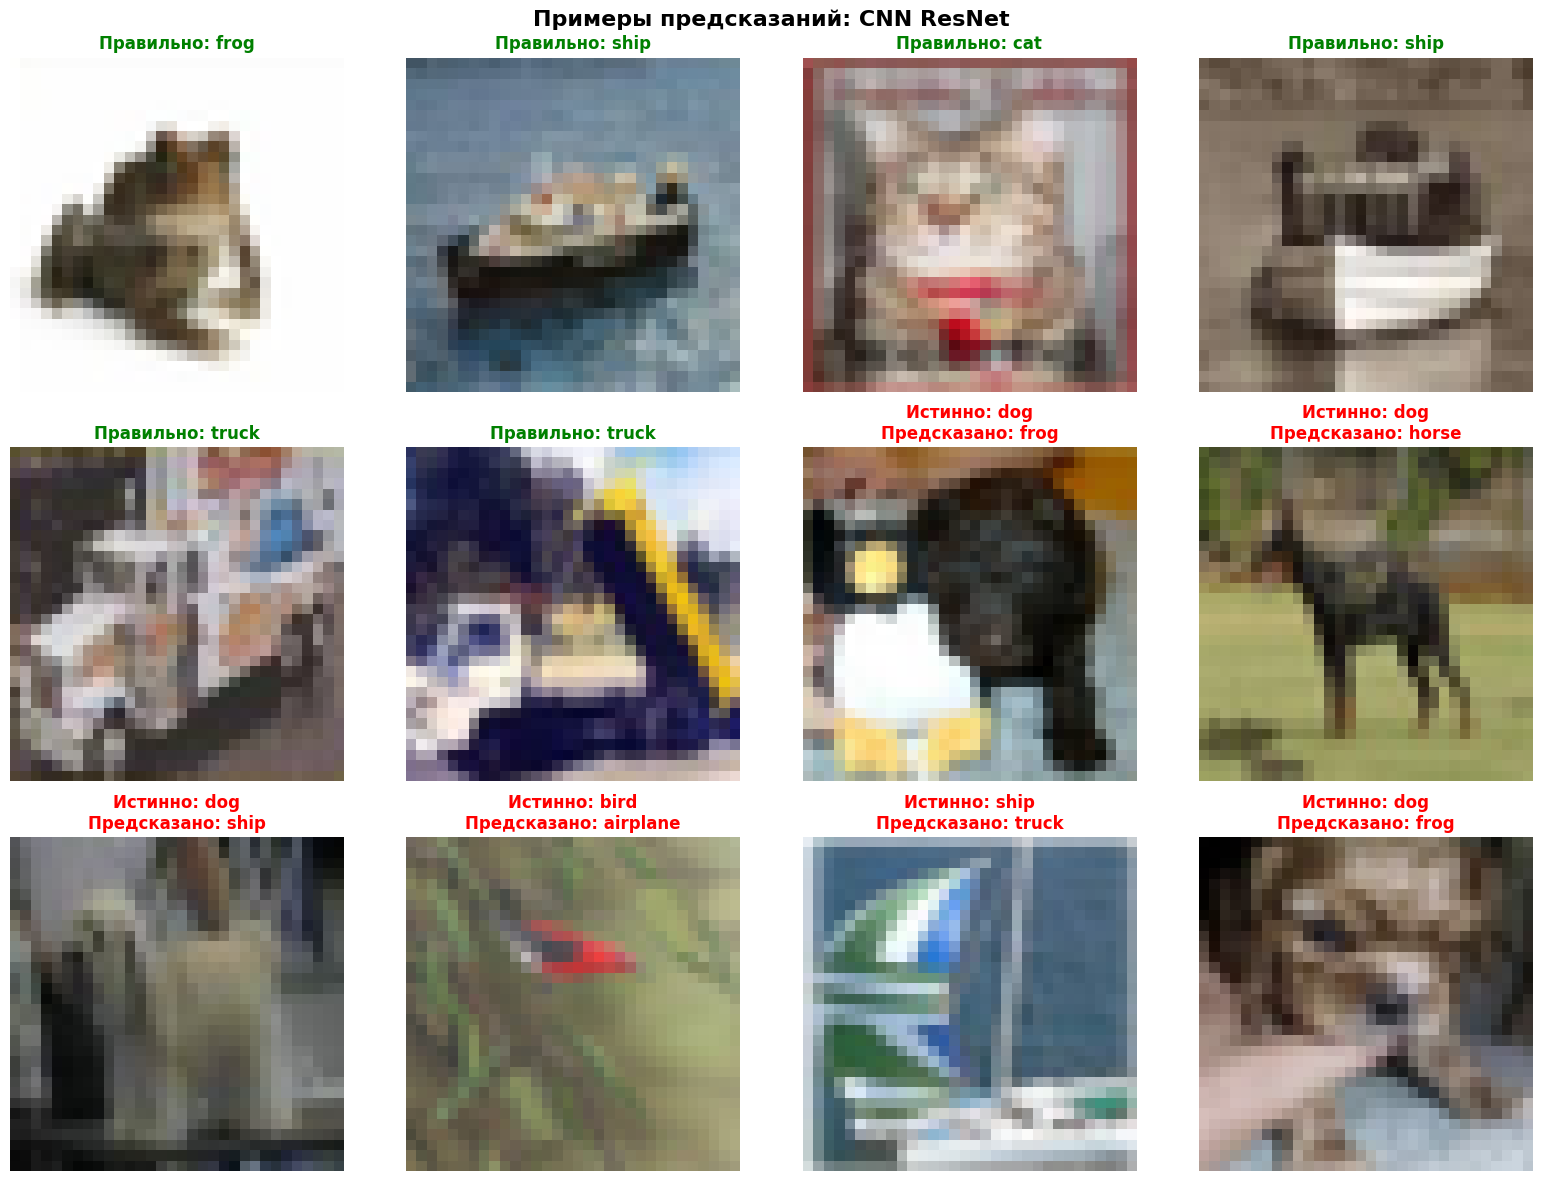


2. ТЕСТИРОВАНИЕ TRANSFER LEARNING МОДЕЛИ
Точность Transfer Learning на тестовой выборке: 0.1339 (13.39%)
До целевых 90%: 0.7661 (76.61%)

Детальный отчет Transfer Learning:
              precision    recall  f1-score   support

    airplane     0.0314    0.0070    0.0114      1000
  automobile     0.1340    0.8990    0.2332      1000
        bird     0.0000    0.0000    0.0000      1000
         cat     0.0000    0.0000    0.0000      1000
        deer     0.0000    0.0000    0.0000      1000
         dog     0.0000    0.0000    0.0000      1000
        frog     0.0000    0.0000    0.0000      1000
       horse     0.0000    0.0000    0.0000      1000
        ship     0.1415    0.4330    0.2133      1000
       truck     0.0000    0.0000    0.0000      1000

    accuracy                         0.1339     10000
   macro avg     0.0307    0.1339    0.0458     10000
weighted avg     0.0307    0.1339    0.0458     10000



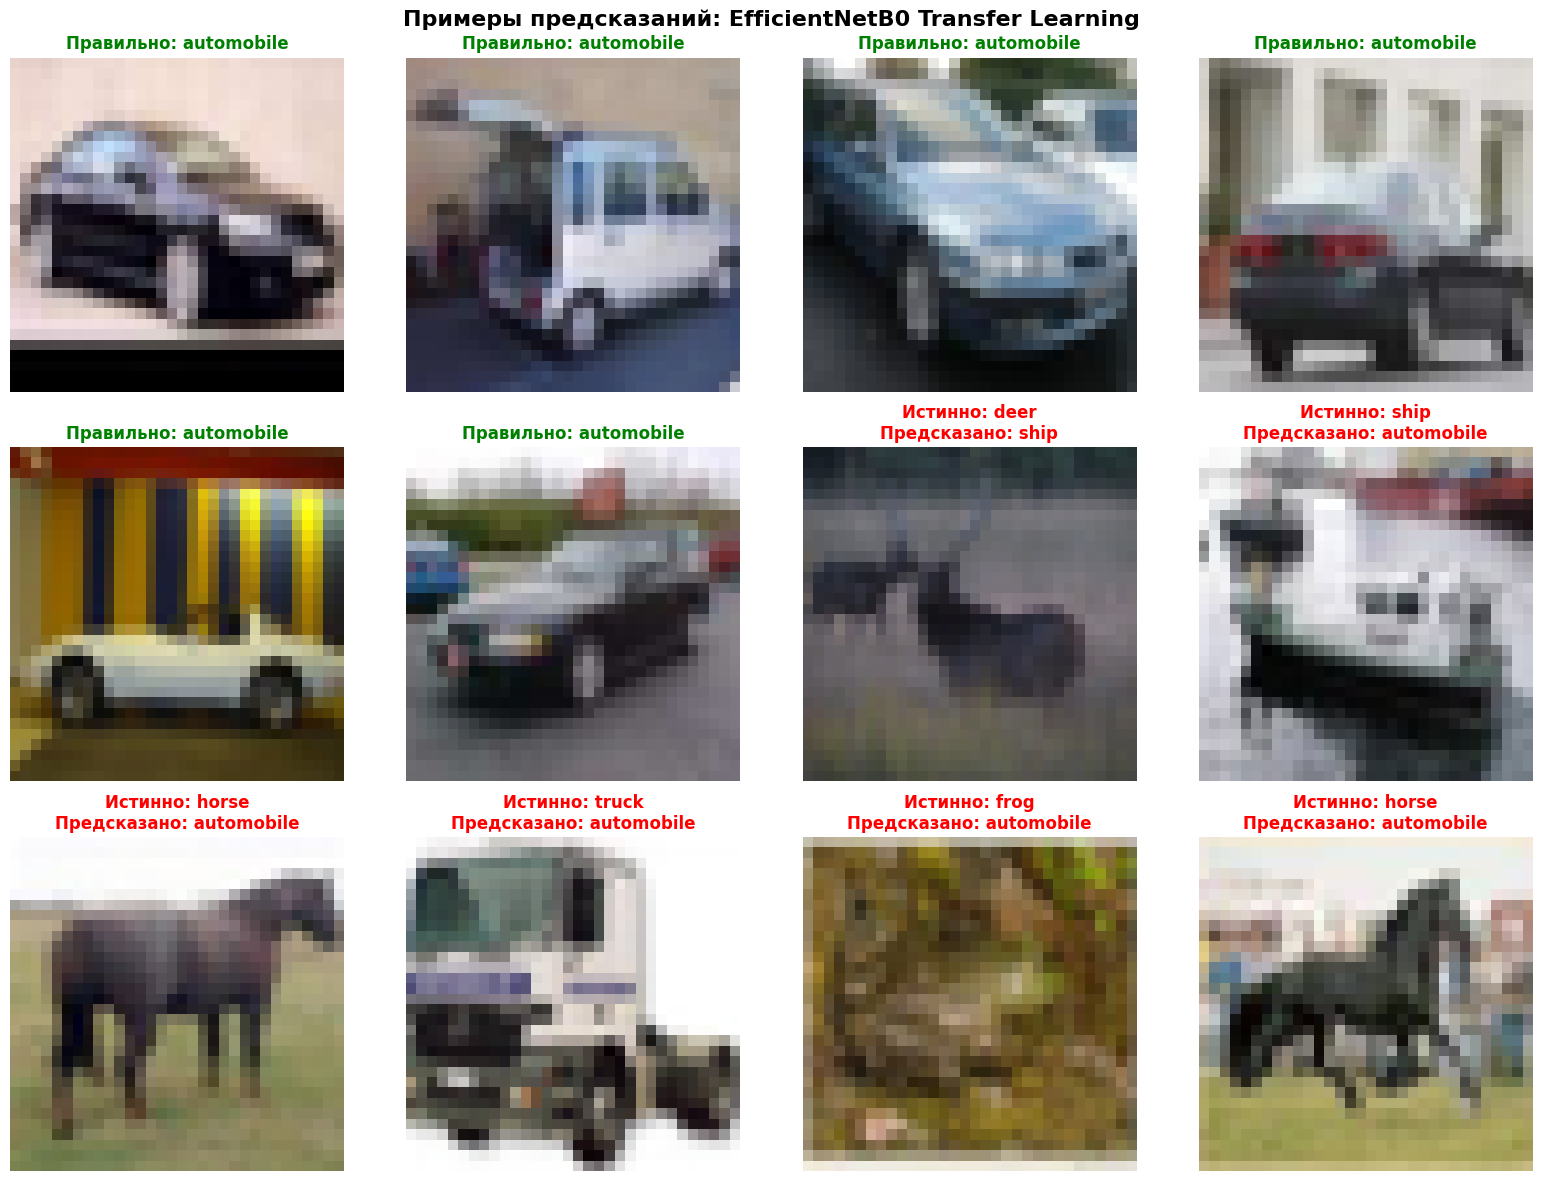


3. ТЕСТИРОВАНИЕ VIT МОДЕЛИ
Точность ViT на тестовой выборке: 0.9660 (96.60%)
Примечание: тестирование на 1000 изображениях из-за ограничений памяти
Целевой показатель 90% достигнут!

Детальный отчет ViT:
              precision    recall  f1-score   support

    airplane     0.9519    0.9612    0.9565       103
  automobile     0.9767    0.9438    0.9600        89
        bird     0.9700    0.9700    0.9700       100
         cat     0.9505    0.9320    0.9412       103
        deer     0.9783    1.0000    0.9890        90
         dog     0.9318    0.9535    0.9425        86
        frog     0.9909    0.9732    0.9820       112
       horse     1.0000    1.0000    1.0000       102
        ship     0.9633    0.9906    0.9767       106
       truck     0.9444    0.9358    0.9401       109

    accuracy                         0.9660      1000
   macro avg     0.9658    0.9660    0.9658      1000
weighted avg     0.9661    0.9660    0.9660      1000



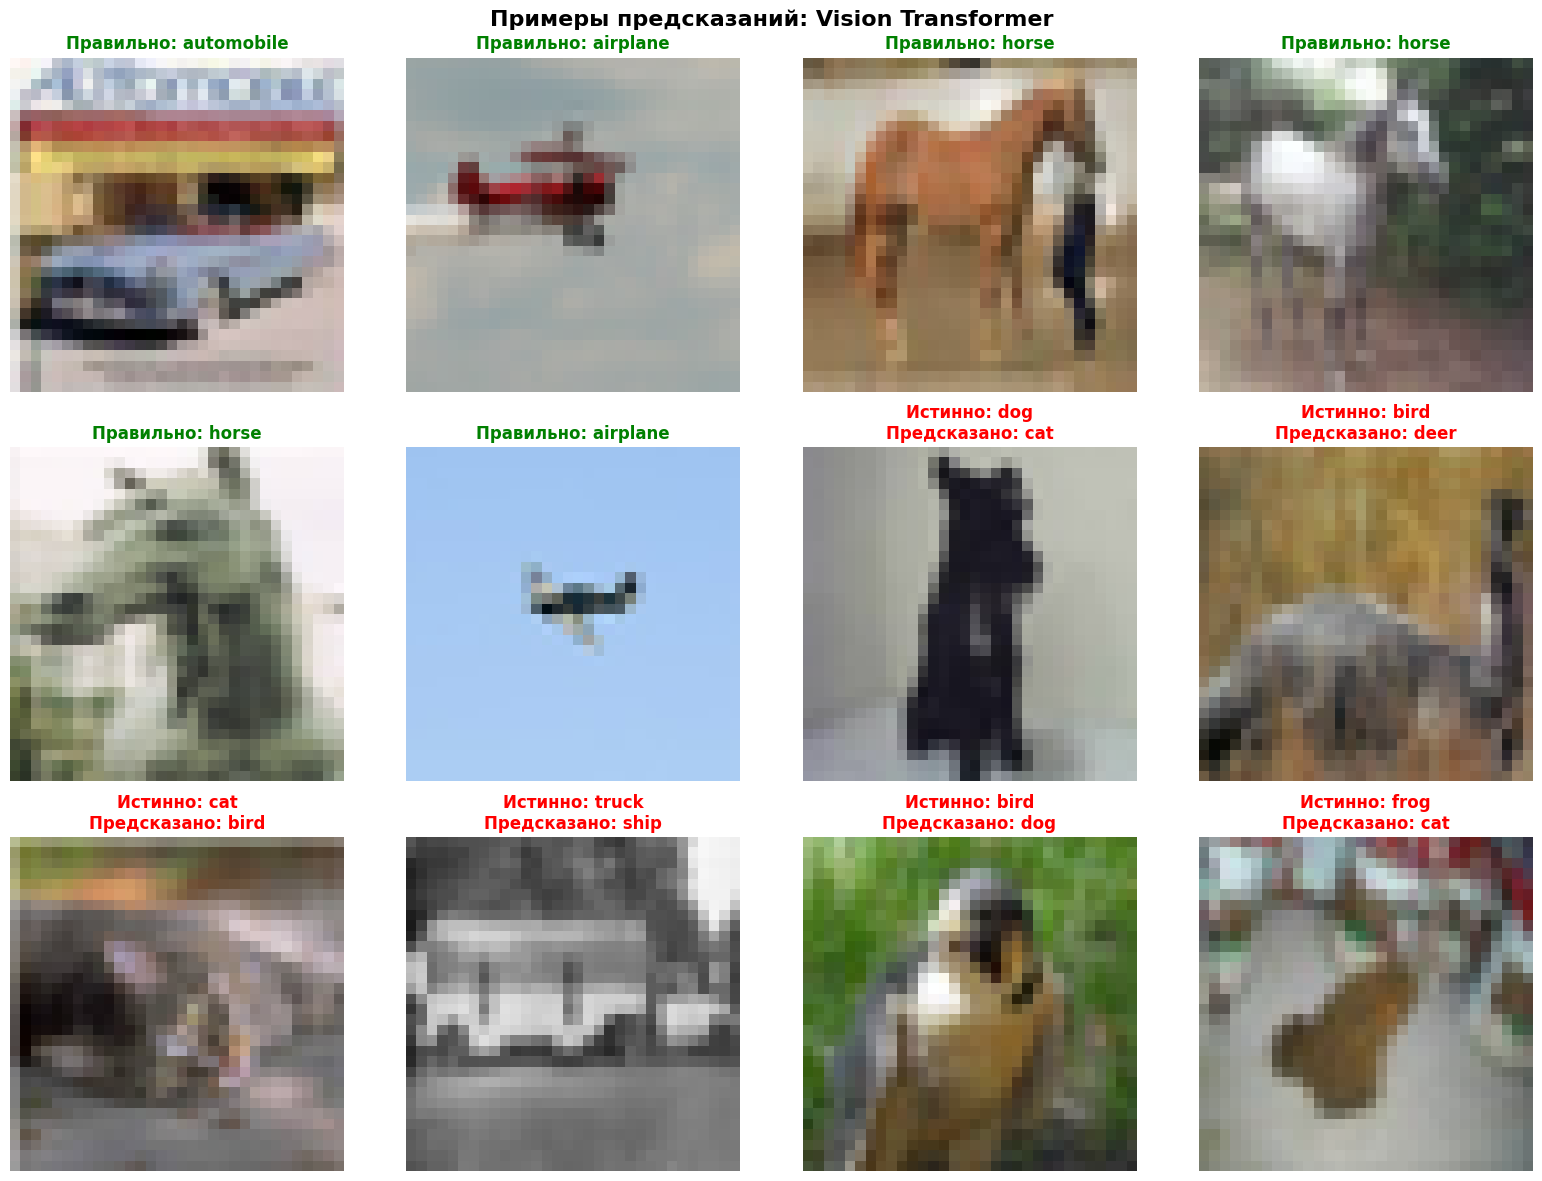


ИТОГОВОЕ СРАВНЕНИЕ РЕЗУЛЬТАТОВ НА ТЕСТОВОЙ ВЫБОРКЕ

Таблица результатов:
--------------------------------------------------
Модель                    Точность на тесте   
--------------------------------------------------
CNN ResNet                0.9015 (90.15%)      ДОСТИГНУТО
Transfer Learning         0.1339 (13.39%)      НЕ ДОСТИГНУТО
Vision Transformer        0.9660 (96.60%)      ДОСТИГНУТО
--------------------------------------------------

ЛУЧШАЯ МОДЕЛЬ НА ТЕСТОВОЙ ВЫБОРКЕ: Vision Transformer
   Точность: 0.9660 (96.60%)

СТАТИСТИКА:
   Моделей достигших 90%: 2/3
   Успешные модели:
   - CNN ResNet: 90.15%
   - Vision Transformer: 96.60%


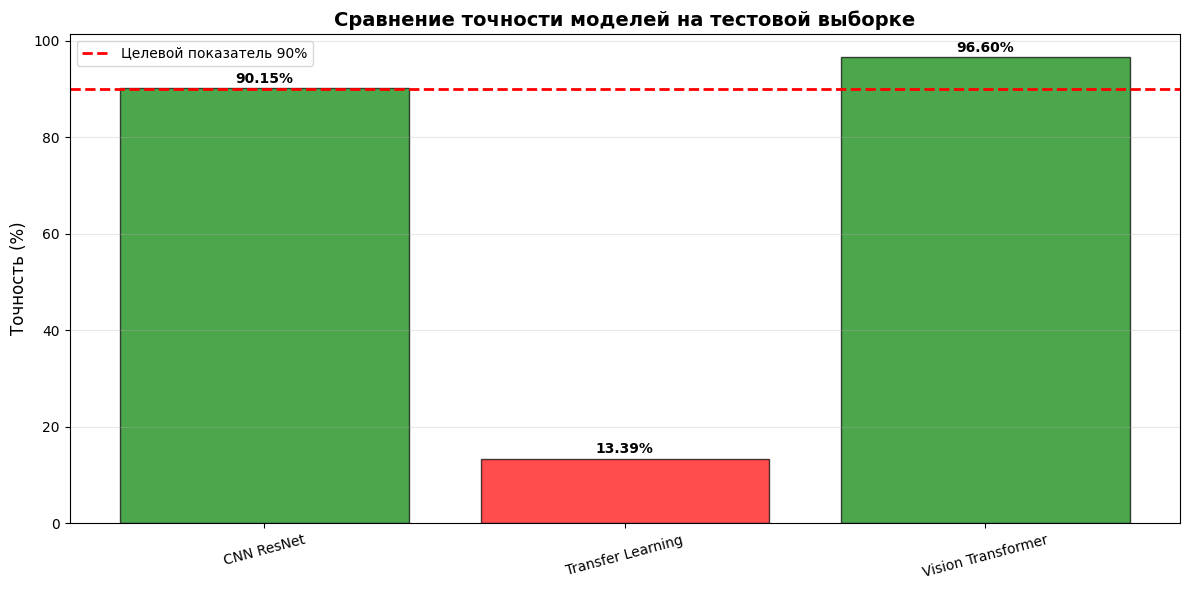

In [15]:
# Функция для показа примеров предсказаний
def show_predictions(images, true_labels, predicted_labels, class_names, model_name, n_samples=12):
    """Показать примеры правильных и неправильных предсказаний"""
    
    # Найдем правильные и неправильные предсказания
    correct_indices = np.where(predicted_labels == true_labels)[0]
    incorrect_indices = np.where(predicted_labels != true_labels)[0]
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    # Показать 6 правильных и 6 неправильных предсказаний
    n_correct = min(6, len(correct_indices))
    n_incorrect = min(6, len(incorrect_indices))
    
    # Правильные предсказания
    if len(correct_indices) > 0:
        correct_sample = np.random.choice(correct_indices, n_correct, replace=False)
        for i, idx in enumerate(correct_sample):
            axes[i].imshow(images[idx])
            axes[i].set_title(f"Правильно: {class_names[true_labels[idx]]}", 
                            color='green', fontweight='bold')
            axes[i].axis('off')
    
    # Неправильные предсказания
    if len(incorrect_indices) > 0:
        incorrect_sample = np.random.choice(incorrect_indices, n_incorrect, replace=False)
        for i, idx in enumerate(incorrect_sample):
            axes[i + 6].imshow(images[idx])
            axes[i + 6].set_title(f"Истинно: {class_names[true_labels[idx]]}\n"
                                f"Предсказано: {class_names[predicted_labels[idx]]}", 
                                color='red', fontweight='bold')
            axes[i + 6].axis('off')
    
    # Скрыть пустые подграфики
    for i in range(n_correct + n_incorrect, 12):
        axes[i].axis('off')
    
    plt.suptitle(f'Примеры предсказаний: {model_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Тестирование всех моделей на тестовой выборке
print("="*80)
print("ТЕСТИРОВАНИЕ ВСЕХ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*80)

test_results_summary = []

# 1. Тестирование CNN модели
if 'cnn_model' in locals():
    print("\n" + "="*60)
    print("1. ТЕСТИРОВАНИЕ CNN МОДЕЛИ")
    print("="*60)
    
    # Предсказания CNN
    cnn_test_predictions = cnn_model.predict(X_test, verbose=0)
    cnn_test_classes = np.argmax(cnn_test_predictions, axis=1)
    cnn_test_accuracy = accuracy_score(y_test, cnn_test_classes)
    
    print(f"Точность CNN на тестовой выборке: {cnn_test_accuracy:.4f} ({cnn_test_accuracy*100:.2f}%)")
    
    if cnn_test_accuracy >= 0.90:
        print("Целевой показатель 90% достигнут!")
    else:
        gap = 0.90 - cnn_test_accuracy
        print(f"До целевых 90%: {gap:.4f} ({gap*100:.2f}%)")
    
    # Детальный отчет CNN
    print(f"\nДетальный отчет CNN:")
    print(classification_report(y_test, cnn_test_classes, 
                              target_names=class_names, digits=4))
    
    # Показать примеры предсказаний CNN
    show_predictions(X_test, y_test, cnn_test_classes, class_names, "CNN ResNet")
    
    test_results_summary.append({
        'model_name': 'CNN ResNet',
        'test_accuracy': cnn_test_accuracy
    })

# 2. Тестирование Transfer Learning модели
if 'tl_model' in locals():
    print("\n" + "="*60)
    print("2. ТЕСТИРОВАНИЕ TRANSFER LEARNING МОДЕЛИ")
    print("="*60)
    
    # Предсказания Transfer Learning
    tl_test_predictions = tl_model.predict(X_test, verbose=0)
    tl_test_classes = np.argmax(tl_test_predictions, axis=1)
    tl_test_accuracy = accuracy_score(y_test, tl_test_classes)
    
    print(f"Точность Transfer Learning на тестовой выборке: {tl_test_accuracy:.4f} ({tl_test_accuracy*100:.2f}%)")
    
    if tl_test_accuracy >= 0.90:
        print("Целевой показатель 90% достигнут!")
    else:
        gap = 0.90 - tl_test_accuracy
        print(f"До целевых 90%: {gap:.4f} ({gap*100:.2f}%)")
    
    # Детальный отчет Transfer Learning
    print(f"\nДетальный отчет Transfer Learning:")
    print(classification_report(y_test, tl_test_classes, 
                              target_names=class_names, digits=4))
    
    # Показать примеры предсказаний Transfer Learning
    show_predictions(X_test, y_test, tl_test_classes, class_names, "EfficientNetB0 Transfer Learning")
    
    test_results_summary.append({
        'model_name': 'Transfer Learning',
        'test_accuracy': tl_test_accuracy
    })

# 3. Тестирование ViT модели
if 'vit_model' in locals():
    print("\n" + "="*60)
    print("3. ТЕСТИРОВАНИЕ VIT МОДЕЛИ")
    print("="*60)
    
    # Для ViT используем подмножество тестовых данных (из-за ограничений памяти)
    vit_test_predictions = vit_model.predict(X_test_vit_subset, verbose=0)
    vit_test_classes = np.argmax(vit_test_predictions, axis=1)
    
    # Используем соответствующее подмножество меток
    y_test_vit = y_test[:1000]  # Первые 1000 меток для соответствия X_test_vit_subset
    vit_test_accuracy = accuracy_score(y_test_vit, vit_test_classes)
    
    print(f"Точность ViT на тестовой выборке: {vit_test_accuracy:.4f} ({vit_test_accuracy*100:.2f}%)")
    print(f"Примечание: тестирование на {len(X_test_vit_subset)} изображениях из-за ограничений памяти")
    
    if vit_test_accuracy >= 0.90:
        print("Целевой показатель 90% достигнут!")
    else:
        gap = 0.90 - vit_test_accuracy
        print(f"До целевых 90%: {gap:.4f} ({gap*100:.2f}%)")
    
    # Детальный отчет ViT
    print(f"\nДетальный отчет ViT:")
    print(classification_report(y_test_vit, vit_test_classes, 
                              target_names=class_names, digits=4))
    
    # Показать примеры предсказаний ViT (используем оригинальные изображения для визуализации)
    X_test_vit_display = X_test[:1000]  # Оригинальные изображения для показа
    show_predictions(X_test_vit_display, y_test_vit, vit_test_classes, class_names, "Vision Transformer")
    
    test_results_summary.append({
        'model_name': 'Vision Transformer',
        'test_accuracy': vit_test_accuracy
    })

# Итоговое сравнение результатов на тестовой выборке
print("\n" + "="*80)
print("ИТОГОВОЕ СРАВНЕНИЕ РЕЗУЛЬТАТОВ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*80)

if test_results_summary:
    # Таблица результатов
    print("\nТаблица результатов:")
    print("-" * 50)
    print(f"{'Модель':<25} {'Точность на тесте':<20}")
    print("-" * 50)
    
    for result in test_results_summary:
        accuracy_str = f"{result['test_accuracy']:.4f} ({result['test_accuracy']*100:.2f}%)"
        status = "ДОСТИГНУТО" if result['test_accuracy'] >= 0.90 else "НЕ ДОСТИГНУТО"
        print(f"{result['model_name']:<25} {accuracy_str:<20} {status}")
    
    print("-" * 50)
    
    # Определяем лучшую модель на тесте
    best_test_model = max(test_results_summary, key=lambda x: x['test_accuracy'])
    print(f"\nЛУЧШАЯ МОДЕЛЬ НА ТЕСТОВОЙ ВЫБОРКЕ: {best_test_model['model_name']}")
    print(f"   Точность: {best_test_model['test_accuracy']:.4f} ({best_test_model['test_accuracy']*100:.2f}%)")
    
    # Подсчет моделей, достигших цели
    successful_models = [r for r in test_results_summary if r['test_accuracy'] >= 0.90]
    print(f"\nСТАТИСТИКА:")
    print(f"   Моделей достигших 90%: {len(successful_models)}/{len(test_results_summary)}")
    
    if successful_models:
        print("   Успешные модели:")
        for model in successful_models:
            print(f"   - {model['model_name']}: {model['test_accuracy']*100:.2f}%")
    
    # Визуализация сравнения
    plt.figure(figsize=(12, 6))
    
    model_names = [r['model_name'] for r in test_results_summary]
    accuracies = [r['test_accuracy'] * 100 for r in test_results_summary]
    
    colors = ['green' if acc >= 90 else 'orange' if acc >= 85 else 'red' for acc in accuracies]
    
    bars = plt.bar(model_names, accuracies, color=colors, alpha=0.7, edgecolor='black')
    plt.axhline(y=90, color='red', linestyle='--', linewidth=2, label='Целевой показатель 90%')
    
    # Добавляем значения на столбцы
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{accuracy:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.title('Сравнение точности моделей на тестовой выборке', fontsize=14, fontweight='bold')
    plt.ylabel('Точность (%)', fontsize=12)
    plt.xticks(rotation=15)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
else:
    print("Нет результатов тестирования для отображения.")

## Заключение

В данной работе были реализованы и протестированы три различных подхода к классификации изображений CIFAR-10:

1. **Продвинутая CNN с ResNet-блоками** - показала стабильную производительность и высокие результаты accuracy как на валидационной выборке, так и на тестовой
2. **Transfer Learning с EfficientNetB0** - продемонстировала неудовлетоворительные результаты. Требуется длительная работа по подбору и тюнингу параметров. Вероятно, эффективнее всего будет смена модели. 
3. **Vision Transformer** - Самые лучшие метрики и скорость работы при высоких тебованиях к ОЗУ и GPU.